POST INTEGRATION PLOTS

In [ ]:
import scanpy as sc
import pandas as pd
import re
import numpy as np
import anndata as ads

adata = sc.read_h5ad("adata_final_regularized.h5ad")

In [2]:
adata

AnnData object with n_obs × n_vars = 154148 × 17818
    obs: 'projid', 'batch', 'individualID', 'species', 'sex', 'race', 'age_death', 'pmi', 'cogdx', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'outlier', 'mt_outlier', 'n_genes', 'doublet_scores', 'predicted_doublets', 'dataset', 'study', 'educ_years', 'hispanic_latino', 'brain_region', 'apoe_genotype_std', 'apoe_e4_dosage', 'apoe_e4_carrier', 'braak_stage', 'braak_label', 'cerad_score_1_4', 'cerad_score_0_3', 'cerad_label', 'mmse', 'moca', 'casi', 'celltype_major', 'celltype_label', 'celltype_supertype', 'celltype_conf', 'doublet_label', 'harmonized', 'AD_status', '_scvi_batch', '_scvi_labels'
    uns: '_scvi_manager_uuid', '_scvi_uuid', 'dataset_colors', 'neighbors', 'umap'
  

Different Leiden Resolutions

IOStream.flush timed out
IOStream.flush timed out
IOStream.flush timed out
IOStream.flush timed out


✅ Computed Leiden clustering at resolution=0.25
✅ Computed Leiden clustering at resolution=0.5
✅ Computed Leiden clustering at resolution=0.75


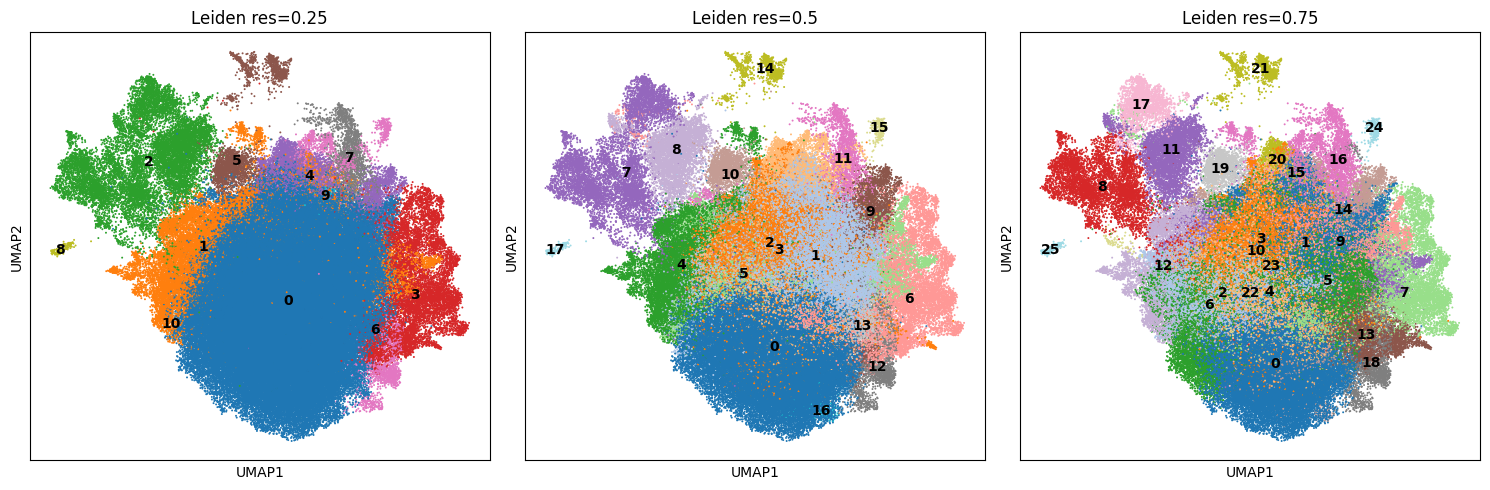

In [4]:
import scanpy as sc
import matplotlib.pyplot as plt
import numpy as np
import os

# ------------------------------------------------------------
# 1. Settings
# ------------------------------------------------------------
outdir = "umap_leiden_resolutions"
os.makedirs(outdir, exist_ok=True)

# Define Leiden resolutions to test
resolutions = [0.25, 0.5, 0.75]

# ------------------------------------------------------------
# 2. Compute neighbors and Leiden clustering for each resolution
# ------------------------------------------------------------
if "neighbors" not in adata.uns:
    sc.pp.neighbors(adata, use_rep="X_scvi")

for res in resolutions:
    key = f"leiden_res_{res}"
    if key not in adata.obs.columns:
        sc.tl.leiden(adata, resolution=res, key_added=key)
        print(f"✅ Computed Leiden clustering at resolution={res}")


# ------------------------------------------------------------
# 4. (Optional) Create one grid showing all resolutions only
# ------------------------------------------------------------
fig, axes = plt.subplots(1, len(resolutions), figsize=(5*len(resolutions), 5))
for i, res in enumerate(resolutions):
    key = f"leiden_res_{res}"
    sc.pl.umap(
        adata,
        color=key,
        ax=axes[i],
        show=False,
        legend_loc="on data",
        title=f"Leiden res={res}",
        palette="tab20",
        size=8,
    )
plt.tight_layout()
#plt.savefig(os.path.join(outdir, "umap_leiden_resolutions_only.png"),
#            dpi=300, bbox_inches="tight")
plt.show()
#plt.close()
#print("✅ Saved UMAP grid for Leiden resolutions only.")


In [5]:
import scanpy as sc
import matplotlib.pyplot as plt
import numpy as np
import os

# ------------------------------------------------------------
# 1. Settings
# ------------------------------------------------------------
outdir = "umap_leiden_by_dataset"
os.makedirs(outdir, exist_ok=True)

# Leiden resolutions already computed (from before)
resolutions = [0.25, 0.5, 0.75]

# Get unique datasets
datasets = sorted(adata.obs["dataset"].unique().tolist())
print(f"📊 Found {len(datasets)} datasets:", datasets)

# ------------------------------------------------------------
# 2. Plot grid per Leiden resolution
# ------------------------------------------------------------
for res in resolutions:
    leiden_key = f"leiden_res_{res}"
    if leiden_key not in adata.obs.columns:
        print(f"⚠️ {leiden_key} not found. Skipping.")
        continue

    # Grid setup
    ncols = 3
    nrows = int(np.ceil(len(datasets) / ncols))
    fig, axes = plt.subplots(nrows, ncols, figsize=(5*ncols, 5*nrows))
    axes = axes.flatten()

    # Loop through datasets
    for i, ds in enumerate(datasets):
        ax = axes[i]
        adata_sub = adata[adata.obs["dataset"] == ds].copy()
        sc.pl.umap(
            adata_sub,
            color=leiden_key,
            ax=ax,
            show=False,
            title=ds,
            palette="tab20",
            legend_loc=None,
            frameon=False,
            size=10,
        )

    # Hide any empty subplots
    for j in range(i+1, len(axes)):
        axes[j].axis("off")

    plt.suptitle(f"Leiden Clustering (Resolution = {res})", fontsize=18, y=1.02)
    plt.tight_layout()
    plt.savefig(os.path.join(outdir, f"umap_leiden_res_{res}_by_dataset_grid.png"),
                dpi=300, bbox_inches="tight")
    plt.close(fig)

    print(f"✅ Saved: umap_leiden_res_{res}_by_dataset_grid.png")

print(f"🎨 All dataset-separated Leiden UMAP grids saved in: {outdir}")


📊 Found 3 datasets: ['FUJITA', 'MIT_ROSMAP', 'SEAAD']
✅ Saved: umap_leiden_res_0.25_by_dataset_grid.png
✅ Saved: umap_leiden_res_0.5_by_dataset_grid.png
✅ Saved: umap_leiden_res_0.75_by_dataset_grid.png
🎨 All dataset-separated Leiden UMAP grids saved in: umap_leiden_by_dataset


Check if clusters 15, 16, 17, 0, 6, 7, 8 are composed of mostly a couple of individuals
Put it in a table how many individualIDs for each of these clusters and also summarize the datasets that are comprised in these clusters 

In [9]:
import pandas as pd

# ------------------------------------------------------------
# 1. Parameters
# ------------------------------------------------------------
leiden_key = "leiden_res_0.5"  # your chosen resolution
clusters_of_interest = [15, 16, 17, 0, 6, 7, 8]

# Make sure the column exists
if leiden_key not in adata.obs.columns:
    raise ValueError(f"{leiden_key} not found in adata.obs")

# ------------------------------------------------------------
# 2. Subset the relevant clusters
# ------------------------------------------------------------
obs = adata.obs.copy()
obs_subset = obs[obs[leiden_key].isin(map(str, clusters_of_interest))]  # Leiden is often string

# Ensure cluster column is numeric or categorical for clarity
obs_subset[leiden_key] = obs_subset[leiden_key].astype(str)

# ------------------------------------------------------------
# 3. Count number of unique individuals per cluster
# ------------------------------------------------------------
cluster_individual_summary = (
    obs_subset.groupby(leiden_key)["individualID"]
    .nunique()
    .reset_index()
    .rename(columns={"individualID": "n_unique_individuals"})
)

# ------------------------------------------------------------
# 4. Summarize dataset composition per cluster
# ------------------------------------------------------------
cluster_dataset_summary = (
    obs_subset.groupby(leiden_key)["dataset"]
    .value_counts(normalize=True)
    .mul(100)
    .round(1)
    .rename("percent")
    .reset_index()
)

# ------------------------------------------------------------
# 5. Merge summaries
# ------------------------------------------------------------
merged_summary = cluster_individual_summary.merge(cluster_dataset_summary, on=leiden_key)

# Sort clusters numerically
merged_summary[leiden_key] = merged_summary[leiden_key].astype(int)
merged_summary = merged_summary.sort_values(by=leiden_key)

# ------------------------------------------------------------
# 6. (Optional) Pretty print and save
# ------------------------------------------------------------
print("📊 Cluster composition summary (resolution 0.5):")
print(merged_summary)

# Save to CSV for convenience
merged_summary.to_csv("cluster_summary_leiden_0.5.csv", index=False)
print("✅ Saved table: cluster_summary_leiden_0.5.csv")


📊 Cluster composition summary (resolution 0.5):
    leiden_res_0.5  n_unique_individuals     dataset  percent
0                0                   496  MIT_ROSMAP     41.5
1                0                   496      FUJITA     41.2
2                0                   496       SEAAD     17.3
14               6                   205  MIT_ROSMAP     11.7
13               6                   205       SEAAD     15.0
12               6                   205      FUJITA     73.3
17               7                   402      FUJITA      3.2
16               7                   402  MIT_ROSMAP     36.3
15               7                   402       SEAAD     60.5
18               8                   294       SEAAD     86.0
20               8                   294      FUJITA      1.2
19               8                   294  MIT_ROSMAP     12.8
5               15                    11      FUJITA      0.9
4               15                    11       SEAAD      3.2
3               15    

/tmp/ipykernel_71131/4257870536.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  obs_subset[leiden_key] = obs_subset[leiden_key].astype(str)


In [14]:
import pandas as pd

# ------------------------------------------------------------
# 1. Parameters
# ------------------------------------------------------------
leiden_key = "leiden_res_0.5"
clusters_of_interest = [15, 16, 17, 0, 6, 7, 8]

# ------------------------------------------------------------
# 2. Subset relevant clusters
# ------------------------------------------------------------
obs = adata.obs.copy()
obs_subset2 = obs[obs[leiden_key].isin(map(str, clusters_of_interest))].copy()

# Safely convert to string to avoid categorical issues
obs_subset2.loc[:, leiden_key] = obs_subset2[leiden_key].astype(str)
obs_subset2.loc[:, "dataset"] = obs_subset2["dataset"].astype(str)

# ------------------------------------------------------------
# 3. Count unique individuals per (cluster, dataset)
# ------------------------------------------------------------
cluster_dataset_individuals = (
    obs_subset2.groupby([leiden_key, "dataset"], observed=True)["individualID"]
    .nunique()
    .reset_index()
    .rename(columns={"individualID": "n_unique_individuals"})
)

# ------------------------------------------------------------
# 4. Compute % of cells per (cluster, dataset)
# ------------------------------------------------------------
cell_counts = (
    obs_subset2.groupby([leiden_key, "dataset"], observed=True)
    .size()
    .reset_index(name="n_cells")
)

cluster_totals = cell_counts.groupby(leiden_key, observed=True)["n_cells"].transform("sum")
cell_counts["percent_cells"] = (100 * cell_counts["n_cells"] / cluster_totals).round(1)

# ------------------------------------------------------------
# 5. Merge summaries (convert before fillna)
# ------------------------------------------------------------
merged_summary = pd.merge(
    cluster_dataset_individuals,
    cell_counts[[leiden_key, "dataset", "percent_cells"]],
    on=[leiden_key, "dataset"],
    how="outer"
)

# Fill NaN only in numeric columns
numeric_cols = ["n_unique_individuals", "percent_cells"]
merged_summary[numeric_cols] = merged_summary[numeric_cols].fillna(0)

# ------------------------------------------------------------
# 6. Sort & save
# ------------------------------------------------------------
merged_summary[leiden_key] = merged_summary[leiden_key].astype(int)
merged_summary = merged_summary.sort_values([leiden_key, "percent_cells"], ascending=[True, False])

print("📊 Cluster composition (per dataset):")
print(merged_summary)

merged_summary.to_csv("cluster_summary_leiden_0.5_by_dataset.csv", index=False)
print("✅ Saved: cluster_summary_leiden_0.5_by_dataset.csv")


📊 Cluster composition (per dataset):
    leiden_res_0.5     dataset  n_unique_individuals  percent_cells
1                0  MIT_ROSMAP                   291           41.5
0                0      FUJITA                   309           41.2
2                0       SEAAD                    58           17.3
3                6      FUJITA                    45           73.3
5                6       SEAAD                    34           15.0
4                6  MIT_ROSMAP                   141           11.7
8                7       SEAAD                    65           60.5
7                7  MIT_ROSMAP                   253           36.3
6                7      FUJITA                   138            3.2
11               8       SEAAD                    64           86.0
10               8  MIT_ROSMAP                   196           12.8
9                8      FUJITA                    50            1.2
13              15  MIT_ROSMAP                     3           95.9
14         

In [7]:
import pandas as pd

# ------------------------------------------------------------
# 1. Parameters
# ------------------------------------------------------------
leiden_key = "leiden_res_0.5"
target_dataset = "MIT_ROSMAP"
clusters_interest = [15, 16, 17]

# ------------------------------------------------------------
# 2. Subset to MIT_ROSMAP and the clusters of interest
# ------------------------------------------------------------
obs = adata.obs.copy()
subset = obs[
    (obs["dataset"] == target_dataset)
    & (obs[leiden_key].isin(map(str, clusters_interest)))
].copy()

subset[leiden_key] = subset[leiden_key].astype(str)

print(f"✅ Subset contains {subset.shape[0]} cells from {target_dataset}")

# ------------------------------------------------------------
# 3. List unique individuals per cluster
# ------------------------------------------------------------
cluster_to_individuals = (
    subset.groupby(leiden_key)["individualID"]
    .unique()
    .apply(list)
    .to_dict()
)

# Display the mapping
for cluster, inds in cluster_to_individuals.items():
    print(f"Cluster {cluster}: {len(inds)} individuals → {inds}")

# ------------------------------------------------------------
# 4. Compute overlaps between clusters
# ------------------------------------------------------------
cluster_sets = {cl: set(ids) for cl, ids in cluster_to_individuals.items()}

# Create a dataframe showing number of shared individuals between each pair
overlap_matrix = pd.DataFrame(
    index=clusters_interest,
    columns=clusters_interest,
    dtype=int
)

for c1 in clusters_interest:
    for c2 in clusters_interest:
        overlap_matrix.loc[c1, c2] = len(cluster_sets[str(c1)] & cluster_sets[str(c2)])

print("\n🔍 Overlap of individualIDs between clusters (MIT_ROSMAP):")
print(overlap_matrix)

# ------------------------------------------------------------
# 5. (Optional) Save results
# ------------------------------------------------------------
pd.DataFrame({
    "cluster": list(cluster_to_individuals.keys()),
    "individualIDs": [", ".join(ids) for ids in cluster_to_individuals.values()],
    "n_individuals": [len(ids) for ids in cluster_to_individuals.values()]
}).to_csv("MIT_ROSMAP_individuals_per_cluster.csv", index=False)

overlap_matrix.to_csv("MIT_ROSMAP_cluster_overlap.csv")

print("✅ Saved: MIT_ROSMAP_individuals_per_cluster.csv and MIT_ROSMAP_cluster_overlap.csv")


✅ Subset contains 567 cells from MIT_ROSMAP
Cluster 15: 3 individuals → ['R9781891', 'R6862468', 'R1292795']
Cluster 16: 8 individuals → ['R1924801', 'R6312023', 'R8054504', 'R3840906', 'R6862468', 'R4174623', 'R9582641', 'R9738414']
Cluster 17: 18 individuals → ['R7696135', 'R9818080', 'R8054504', 'R6911631', 'R1830086', 'R3898113', 'R4817881', 'R3128463', 'R4184741', 'R8998310', 'R1944372', 'R6415047', 'R9088015', 'R2549195', 'R5459434', 'R2709337', 'R6411801', 'R6913259']

🔍 Overlap of individualIDs between clusters (MIT_ROSMAP):
     15   16    17
15  3.0  1.0   0.0
16  1.0  8.0   1.0
17  0.0  1.0  18.0
✅ Saved: MIT_ROSMAP_individuals_per_cluster.csv and MIT_ROSMAP_cluster_overlap.csv


✅ Subset: 567 cells from MIT_ROSMAP in clusters ['15', '16', '17']


/tmp/ipykernel_71131/470228579.py:36: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(


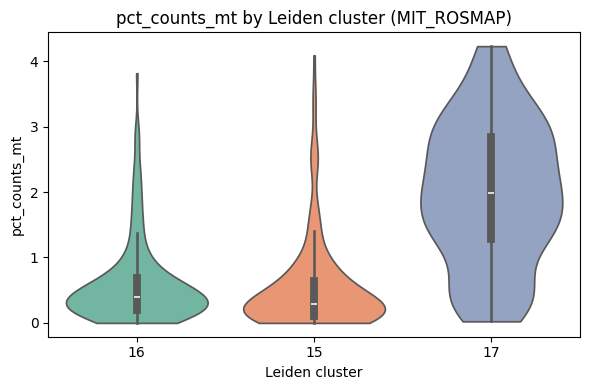

/tmp/ipykernel_71131/470228579.py:36: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(


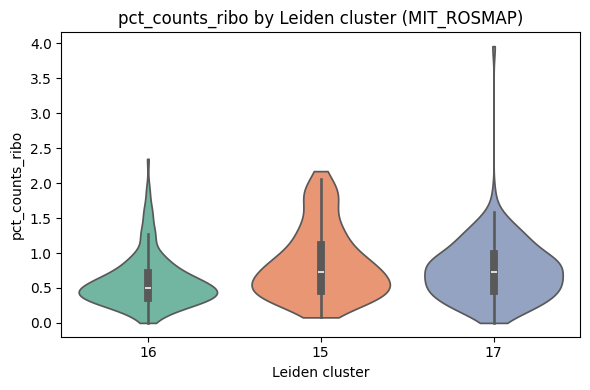

/tmp/ipykernel_71131/470228579.py:36: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(


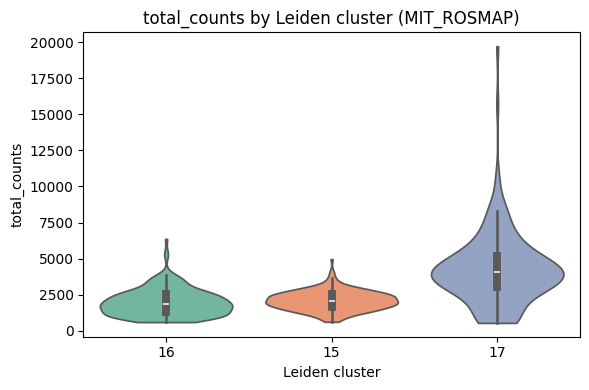

/tmp/ipykernel_71131/470228579.py:36: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(


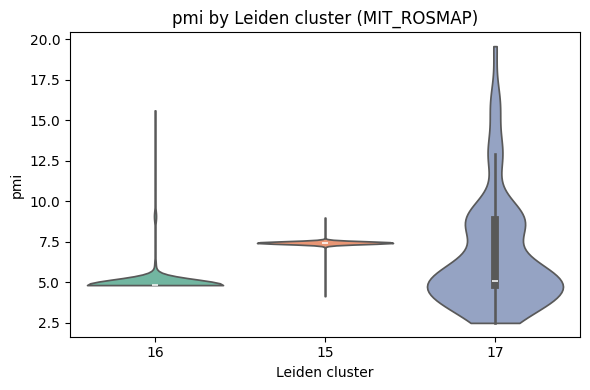

/tmp/ipykernel_71131/470228579.py:36: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(


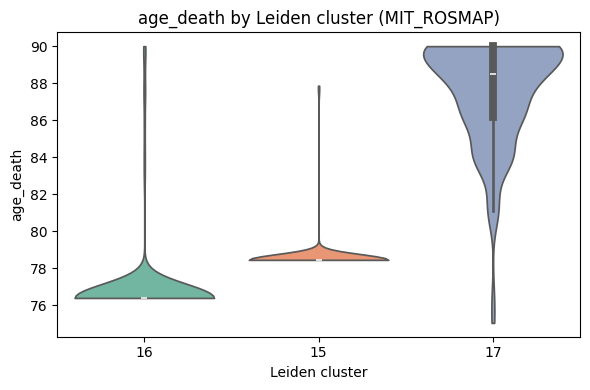

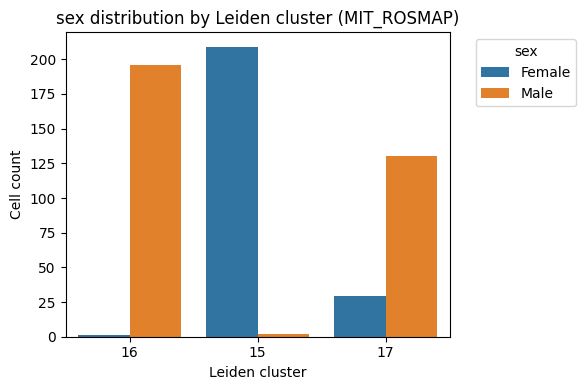

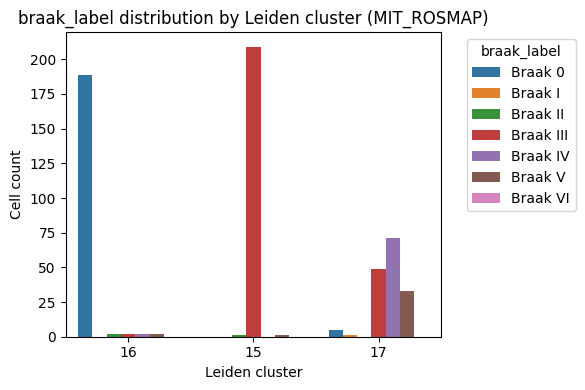

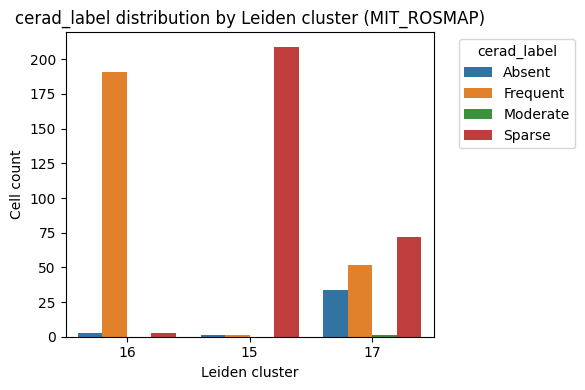

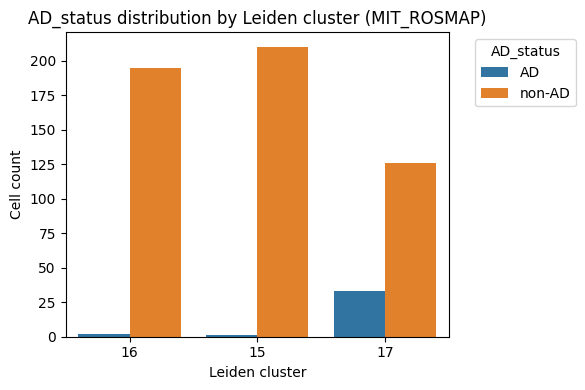

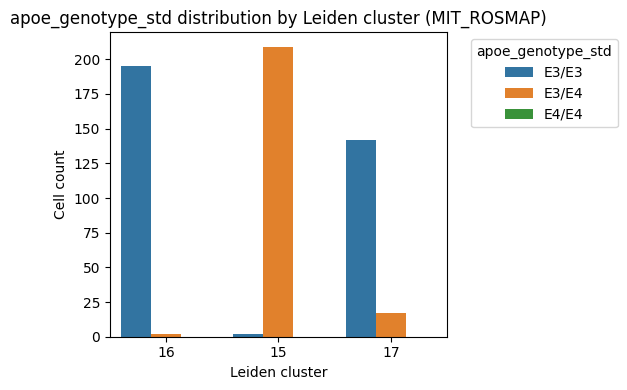

In [17]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# ------------------------------------------------------------
# 1. Parameters
# ------------------------------------------------------------
leiden_key = "leiden_res_0.5"
target_dataset = "MIT_ROSMAP"
clusters_interest = ["15", "16", "17"]

# ------------------------------------------------------------
# 2. Subset data
# ------------------------------------------------------------
obs = adata.obs.copy()
subset = obs[
    (obs["dataset"] == target_dataset)
    & (obs[leiden_key].isin(clusters_interest))
].copy()

subset[leiden_key] = subset[leiden_key].astype(str)

print(f"✅ Subset: {subset.shape[0]} cells from {target_dataset} in clusters {clusters_interest}")

# ------------------------------------------------------------
# 3. Numeric metadata: plot distributions
# ------------------------------------------------------------
numeric_vars = ["pct_counts_mt", "pct_counts_ribo", "total_counts", "pmi", "age_death"]

for var in numeric_vars:
    if var not in subset.columns:
        print(f"⚠️ {var} not found in obs, skipping.")
        continue

    plt.figure(figsize=(6, 4))
    sns.violinplot(
        data=subset,
        x=leiden_key,
        y=var,
        inner="box",
        palette="Set2",
        cut=0
    )
    plt.title(f"{var} by Leiden cluster ({target_dataset})")
    plt.xlabel("Leiden cluster")
    plt.ylabel(var)
    plt.tight_layout()
    plt.show()

# ------------------------------------------------------------
# 4. Categorical metadata: plot counts
# ------------------------------------------------------------
categorical_vars = ["sex", "braak_label", "cerad_label", "AD_status", "apoe_genotype_std"]

for var in categorical_vars:
    if var not in subset.columns:
        print(f"⚠️ {var} not found in obs, skipping.")
        continue

    plt.figure(figsize=(6, 4))
    sns.countplot(
        data=subset,
        x=leiden_key,
        hue=var,
        palette="tab10"
    )
    plt.title(f"{var} distribution by Leiden cluster ({target_dataset})")
    plt.xlabel("Leiden cluster")
    plt.ylabel("Cell count")
    plt.legend(title=var, bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()


✅ Subset: 20225 cells in clusters ['6', '7', '8']


/tmp/ipykernel_71131/1881717597.py:34: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(
/tmp/ipykernel_71131/1881717597.py:48: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(


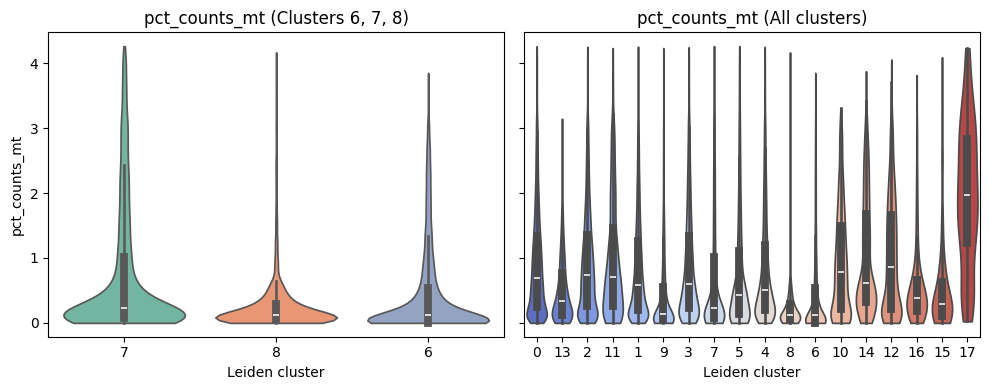

/tmp/ipykernel_71131/1881717597.py:34: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(
/tmp/ipykernel_71131/1881717597.py:48: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(


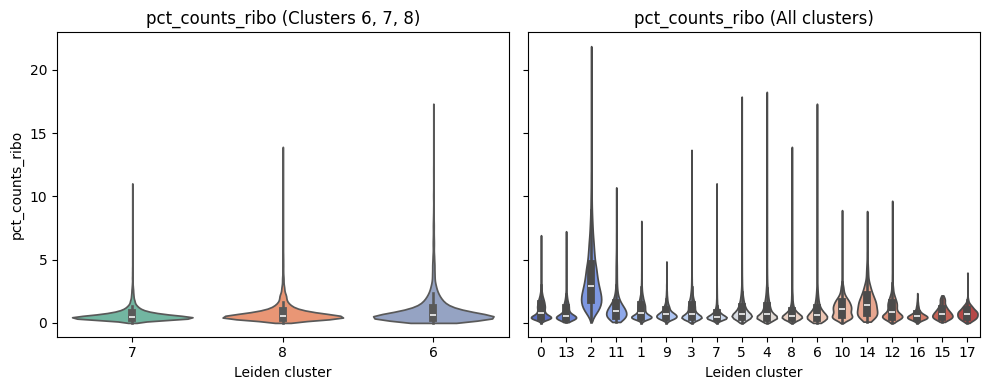

/tmp/ipykernel_71131/1881717597.py:34: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(
/tmp/ipykernel_71131/1881717597.py:48: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(


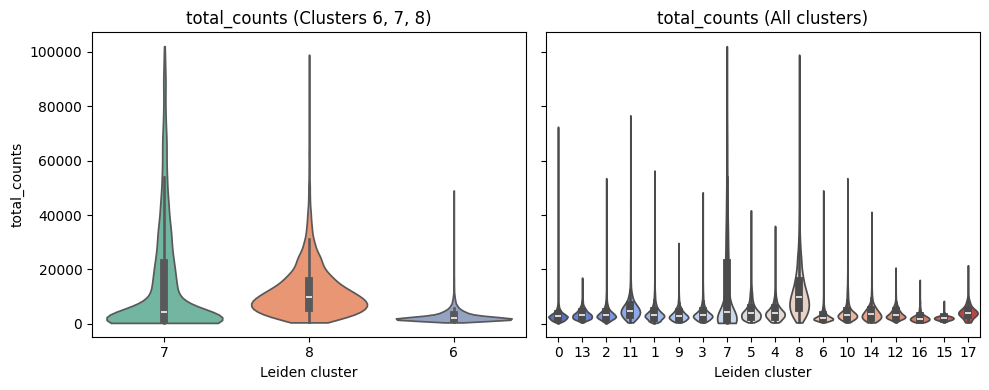

/tmp/ipykernel_71131/1881717597.py:34: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(
/tmp/ipykernel_71131/1881717597.py:48: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(


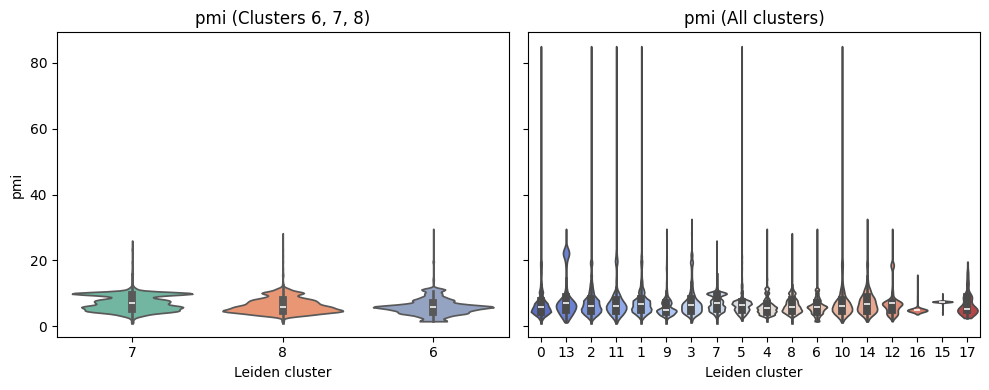

/tmp/ipykernel_71131/1881717597.py:34: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(
/tmp/ipykernel_71131/1881717597.py:48: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(


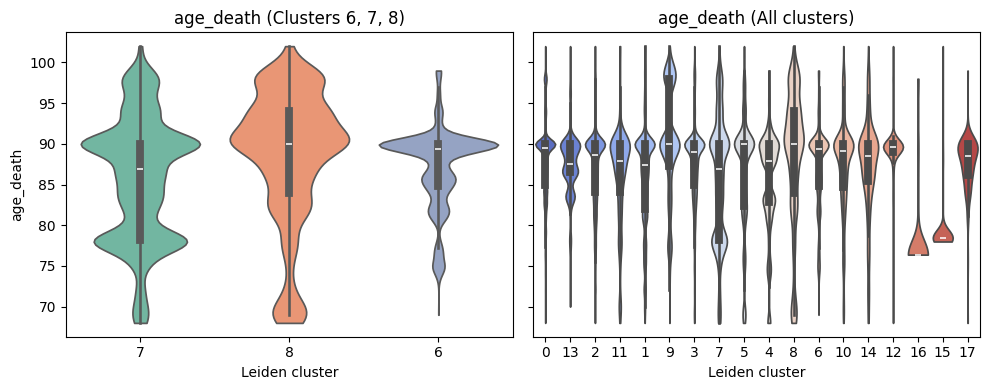

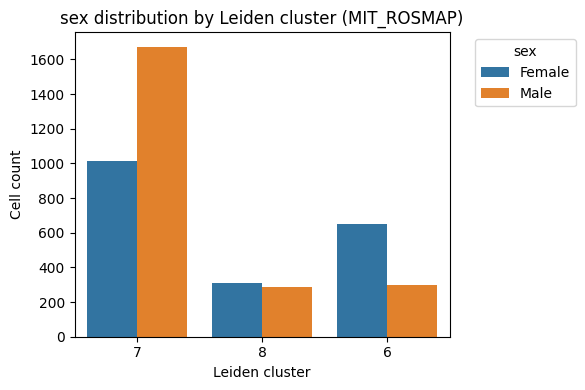

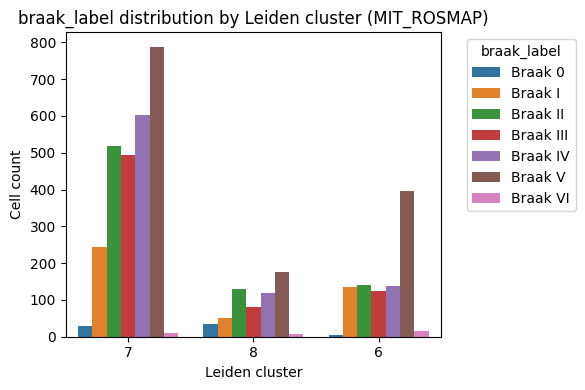

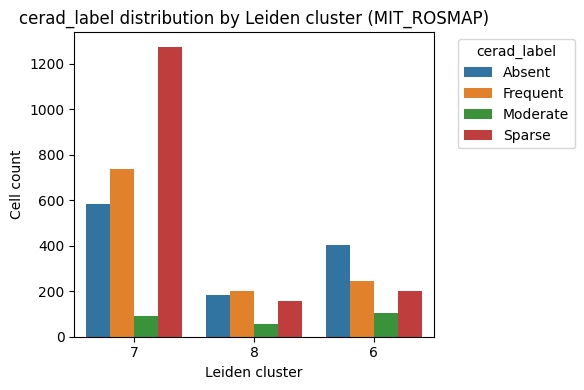

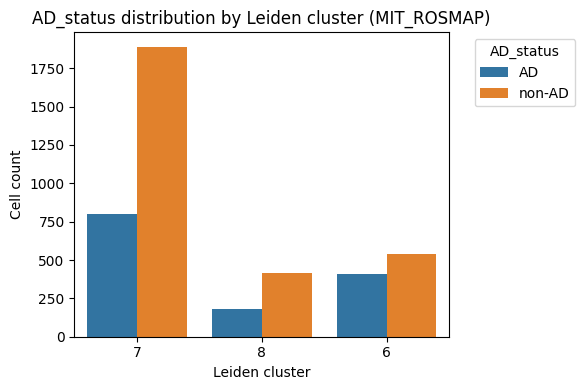

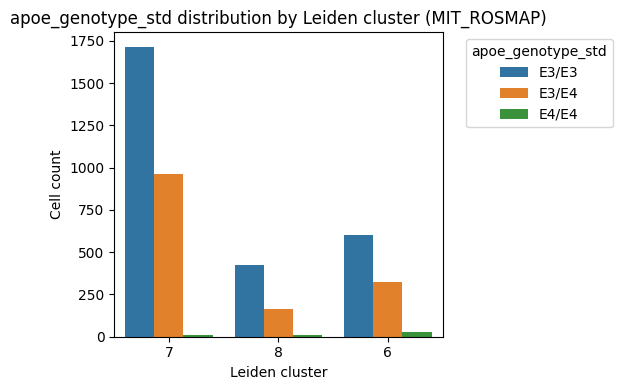

In [21]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# ------------------------------------------------------------
# 1. Parameters
# ------------------------------------------------------------
leiden_key = "leiden_res_0.5"
clusters_interest = ["6", "7", "8"]

# ------------------------------------------------------------
# 2. Prepare data
# ------------------------------------------------------------
obs = adata.obs.copy()
obs[leiden_key] = obs[leiden_key].astype(str)

subset_interest = obs[obs[leiden_key].isin(clusters_interest)].copy()

print(f"✅ Subset: {subset_interest.shape[0]} cells in clusters {clusters_interest}")

# ------------------------------------------------------------
# 3. Numeric metadata: compare clusters of interest vs all clusters
# ------------------------------------------------------------
numeric_vars = ["pct_counts_mt", "pct_counts_ribo", "total_counts", "pmi", "age_death"]

for var in numeric_vars:
    if var not in obs.columns:
        print(f"⚠️ {var} not found in obs, skipping.")
        continue

    fig, axes = plt.subplots(1, 2, figsize=(10, 4), sharey=True)

    # Left: only clusters of interest
    sns.violinplot(
        data=subset_interest,
        x=leiden_key,
        y=var,
        inner="box",
        palette="Set2",
        cut=0,
        ax=axes[0]
    )
    axes[0].set_title(f"{var} (Clusters {', '.join(clusters_interest)})")
    axes[0].set_xlabel("Leiden cluster")
    axes[0].set_ylabel(var)

    # Right: all clusters across dataset
    sns.violinplot(
        data=obs,
        x=leiden_key,
        y=var,
        inner="box",
        palette="coolwarm",
        cut=0,
        ax=axes[1]
    )
    axes[1].set_title(f"{var} (All clusters)")
    axes[1].set_xlabel("Leiden cluster")
    axes[1].set_ylabel("")

    plt.tight_layout()
    plt.show()

# ------------------------------------------------------------
# 4. Categorical metadata: plot counts
# ------------------------------------------------------------
categorical_vars = ["sex", "braak_label", "cerad_label", "AD_status", "apoe_genotype_std"]

for var in categorical_vars:
    if var not in subset.columns:
        print(f"⚠️ {var} not found in obs, skipping.")
        continue

    plt.figure(figsize=(6, 4))
    sns.countplot(
        data=subset,
        x=leiden_key,
        hue=var,
        palette="tab10"
    )
    plt.title(f"{var} distribution by Leiden cluster ({target_dataset})")
    plt.xlabel("Leiden cluster")
    plt.ylabel("Cell count")
    plt.legend(title=var, bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()


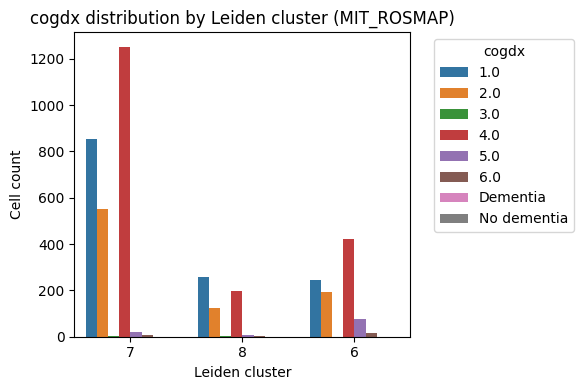

/tmp/ipykernel_71131/2642532394.py:22: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


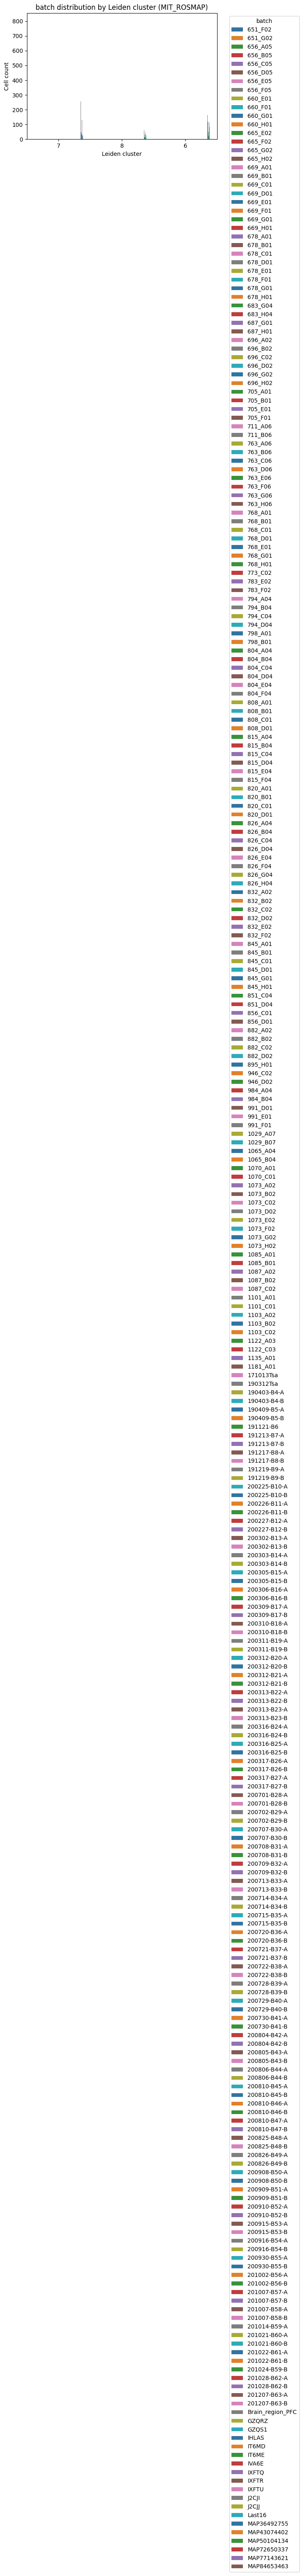

In [22]:
# ------------------------------------------------------------
# 4. Categorical metadata: plot counts
# ------------------------------------------------------------
categorical_vars = ["cogdx", "batch"]

for var in categorical_vars:
    if var not in subset.columns:
        print(f"⚠️ {var} not found in obs, skipping.")
        continue

    plt.figure(figsize=(6, 4))
    sns.countplot(
        data=subset,
        x=leiden_key,
        hue=var,
        palette="tab10"
    )
    plt.title(f"{var} distribution by Leiden cluster ({target_dataset})")
    plt.xlabel("Leiden cluster")
    plt.ylabel("Cell count")
    plt.legend(title=var, bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()


# DGE for clusters 6 7 8

In [ ]:
import scanpy as sc
import pandas as pd
import os

# ------------------------------------------------------------
# 1. Parameters
# ------------------------------------------------------------
leiden_key = "leiden_res_0.5"
clusters_of_interest = ["6", "7", "8"]
outdir = "dge_clusters_6_7_8_vs_rest"
os.makedirs(outdir, exist_ok=True)


adata_dge = adata.copy()

# Normalize and log-transform (Seurat-like pipeline)
sc.pp.normalize_total(adata_dge, target_sum=1e4)
sc.pp.log1p(adata_dge)


# ------------------------------------------------------------
# 2. Loop over clusters and perform DGE
# ------------------------------------------------------------
for cluster in clusters_of_interest:
    print(f"\n🔬 Running differential expression for cluster {cluster} vs all others...")

    # Define groups
    sc.tl.rank_genes_groups(
        adata_dge,
        groupby=leiden_key,
        groups=[cluster],
        reference="rest",  # compare against all other clusters
        method="wilcoxon", # other options: 't-test', 'logreg'
        pts=True,          # adds fraction of cells expressing the gene
        use_raw= False 
    )

    # Convert to a dataframe
    result = adata_dge.uns["rank_genes_groups"]
    groups = result["names"].dtype.names

    df = pd.DataFrame({
        group + "_" + key: result[key][group]
        for group in groups
        for key in ["names", "scores", "logfoldchanges", "pvals_adj", "pvals", "pts", "pts_rest"]
    })

    # Extract just the current cluster
    cluster_df = pd.DataFrame({
        "gene": result["names"][cluster],
        "log2FC": result["logfoldchanges"][cluster],
        "score": result["scores"][cluster],
        "pval": result["pvals"][cluster],
        "pval_adj": result["pvals_adj"][cluster],
        "pct_expr_cluster": result["pts"][cluster],
        "pct_expr_rest": result["pts_rest"][cluster],
    })

    cluster_df = cluster_df.sort_values("pval_adj", ascending=True)

    # Save to file
    cluster_df.to_csv(os.path.join(outdir, f"DGE_cluster_{cluster}_vs_rest.csv"), index=False)
    print(f"✅ Saved DGE results for cluster {cluster} → DGE_cluster_{cluster}_vs_rest.csv")



🔬 Running differential expression for cluster 6 vs all others...


In [ ]:
import scanpy as sc
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os

# ------------------------------------------------------------
# 1. Parameters
# ------------------------------------------------------------
leiden_key = "leiden_res_0.5"
clusters_of_interest = ["6", "7", "8"]
outdir = "dge_clusters_6_7_8_vs_rest"
combined_filtered_path = os.path.join(outdir, "DGE_combined_filtered_clusters_6_7_8.csv")

# ------------------------------------------------------------
# 2. Load and combine DGE CSVs
# ------------------------------------------------------------
dge_tables = []
for cluster in clusters_of_interest:
    file_path = os.path.join(outdir, f"DGE_cluster_{cluster}_vs_rest.csv")
    if not os.path.exists(file_path):
        print(f"⚠️ File not found: {file_path}, skipping.")
        continue

    df = pd.read_csv(file_path)
    df["cluster"] = cluster
    dge_tables.append(df)

# Combine all
combined_df = pd.concat(dge_tables, ignore_index=True)
print(f"✅ Loaded DGE results: {combined_df.shape[0]} total genes across clusters.")

# ------------------------------------------------------------
# 3. Filter for significance
# ------------------------------------------------------------
filtered_df = combined_df[
    (combined_df["pval_adj"] < 0.05) &
    (combined_df["log2FC"] > 0.25)
].copy()
print(f"✅ Filtered to {filtered_df.shape[0]} significant upregulated genes.")

# ------------------------------------------------------------
# 4. Select top 10 DEGs per cluster (by adjusted p-value)
# ------------------------------------------------------------
top_genes_df = (
    filtered_df.sort_values(["cluster", "pval_adj"], ascending=[True, True])
    .groupby("cluster")
    .head(10)
)

top_genes = top_genes_df["gene"].unique().tolist()
print(f"✅ Selected top {len(top_genes)} genes across clusters.")

# ------------------------------------------------------------
# 5. Extract expression data from AnnData
# ------------------------------------------------------------
adata_subset = adata[:, top_genes].copy()

# Optionally, use raw counts if available
X = adata_subset.raw.X if adata_subset.raw is not None else adata_subset.X

# Convert to DataFrame
expr_df = pd.DataFrame(
    X.toarray() if not isinstance(X, np.ndarray) else X,
    index=adata_subset.obs_names,
    columns=adata_subset.var_names
)
expr_df[leiden_key] = adata_subset.obs[leiden_key].astype(str)

# Compute average expression per cluster
avg_expr = expr_df.groupby(leiden_key).mean()
avg_expr = avg_expr.loc[sorted(avg_expr.index.astype(int))]  # order clusters numerically

# Normalize expression for better visualization
avg_expr_z = (avg_expr - avg_expr.mean()) / avg_expr.std()

# ------------------------------------------------------------
# 6. Plot heatmap
# ------------------------------------------------------------
plt.figure(figsize=(12, 6))
sns.heatmap(
    avg_expr_z.loc[clusters_of_interest, top_genes].T,
    cmap="vlag",
    center=0,
    linewidths=0.5,
    cbar_kws={"label": "Z-score"}
)
plt.title("Top 10 DEGs per cluster (clusters 6, 7, 8)")
plt.xlabel("Leiden cluster")
plt.ylabel("Gene")
plt.tight_layout()
plt.show()

# ------------------------------------------------------------
# 7. (Optional) Save combined table
# ------------------------------------------------------------
top_genes_df.to_csv(combined_filtered_path, index=False)
print(f"✅ Saved combined filtered DEGs → {combined_filtered_path}")
